In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.31.0
Using datasets v2.10.1
Using accelerate v0.21.0
Using optuna v3.2.0
Using onnxruntime v1.15.1
Using onnx v1.14.0


# 8장
지식정제,  
동적 패딩,  
가중치 양자화,  
가지치기,  
ONNX 포맷과 ONNX 런타임(ORT)을 사용한 그래프 최적화

# 8.1 의도 탐지

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
# 준비한 파이프라인에 쿼리를 전달해 모델로부터 예측한 의도와 신뢰도 점수를 얻는다.

query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

# 8.2 기준 모델의 성능을 평가할 벤치마크 클래스 만들기

신경써야 할 조건 3가지  
1. 모델 성능  
2. 레이턴시  
3. 메모리  
  
이런 제약 조건을 해결하지 못하면 애플리케이션의 사용자 경험에 부정적 영향을 미침

### 파이프라인과 테스트 세트가 주어지면 성능을 측정하는 간단한 벤치마크 클래스

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        # 나중에 정의한다.
        pass
    
    def compute_size(self):
        # 나중에 정의한다.
        pass
    
    def time_pipeline(self):
        # 나중에 정의한다.
        pass

    # optim_type을 키로 모든 지표를 저장
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline()) # 딕셔너리의 update 메서드는 새로운 'key와 value'를 추가하거나 수정
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus") # plus 설정은 범위 밖의 훈련 샘플이 담긴 서브셋을 의미함

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

의도intent는 ID로 제공됨.  
다만 feature 속성을 사용하면 문자열로(그리고 반대로도) 쉽게 매핑 가능하다.

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

PerformanceBenchmark의 compute_accuracy() 메서드를 구현해보자.  
이 데이터셋은 의도 클래스 간에 균형이 잡혀 있으니(42만 250개 나머지는 100개씩 존재, 총 151개의 클래스 0~150) 성능 지표로 accuracy를 사용

In [8]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

/tmp/ipykernel_1484/3510557904.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


### 파이프라인을 사용해 text 필드에서 예측을 추출하고, intents 객체의 str2int() 메서드를 사용해 각 예측을 해당 ID로 매핑한다.

In [9]:
def compute_accuracy(self):
    """PerformanceBenchmar.compute_accuracy() 메서드를 오버라이드한다."""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

각각의 키/값 쌍이 BERT의 층과 텐서에 해당한다.

In [11]:
# torch.save(pipe.model.state_dict(), "model.pt")

파이썬의 pathlib 모듈의 Path.stat() 함수를 사용해 저장된 파일의 정보를 얻는다.  
Path("model.pt").stat().st_size에는 모델 크기가 바이트 단위로 저장됐다.

In [12]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산한다.
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제한다.
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}
    
PerformanceBenchmark.compute_size = compute_size

쿼리마다 평균적인 레이턴시를 재기 위해 time_pipeline() 함수를 구현한다.

이 애플리케이션에서 레이턴시는  
-> 파이프라인에 텍스트 쿼리를 주입하고 모델로부터 예측된 의도가 반환되기까지 걸린 시간을 의미한다.

파이썬의 time 모델이 제공하는 perf_counter() 함수는 time.time() 함수보다 더 미세한 수준으로 시간을 측정해 정밀한 결과를 요하는 곳에 적합하다.

In [13]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000*latency:.3f}") # 할 때 마다  값이 바뀜

레이턴시 (ms) - 35.202
레이턴시 (ms) - 29.625
레이턴시 (ms) - 29.490


### 파이프라인을 여러 번 실행해 레이턴시를 수집하고 그 결과의 평균과 표준 편차를 계산한 후, 분포를 구해 값이 얼마나 퍼져 있는지 파악한다.

In [14]:
import numpy as np

def time_pipeline(self, query = "What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다."""
    latencies = []
    
    # CPU 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    
    # 통계 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms":time_avg_ms, "time_std_ms":time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 25.47 +\- 5.49
테스트 세트 정확도 - 0.867


평균 레이턴시 값은 사용하는 하드웨어 종류에 따라 달라진다.  
예를 들어 GPU에서 추론을 실행하면 배치 처리가 가능해서 대개는 성능이 좋아진다.  
이 장의 목적상 모델 간의 상대적인 레이턴시 차이가 중요하다.  
최상의 모델을 결정했다면 필요에 따라 적절한 하드웨어를 사용해 레이턴시의 절댓값을 줄일 수 있다.

#### 기준 점수를 얻었으니 첫 번째 압축 기술로서 지식 정제를 살펴보자.

# 8.3 지식 정제로 모델 크기 줄이기

지식 정제 -> 작은 student 모델을 훈련하는 방법  
느리고 크지만 성능이 더 높은 teacher의 동작을 모방하도록 작은 student 모델을 훈련한다.

## 8.3.1 미세 튜닝에서의 지식 정제
미세 튜닝 같은 지도 학습 작업에서는 teacher의 소프트 확률(soft probabilty)로 정답 레이블을 보강해서 student가 학습할 때 부가 정보를 제공하는 것이 주요 아이디어다.

예를 들어, BERT 기반 분류기가 여러 개의 의도에 높은 확률을 할당한다면, 이 의도는 특성 공간 안에서 서로 가까이 위치한다는 신호일 가능성이 있다.

이런 확률을 모방하도록 student를 훈련해서 teacher가 학습한 '검은 지식(dark knowledge)'을 정제한다.  
※ 검은 지식: 레이블만으로는 얻지 못하는 지식

## 8.3.2 사전 훈련에서의 지식 정제

사전 훈련하는 동안 후속 작업에서 미세 튜닝이 가능한 범용 스튜던트를 만들기 위해 지식 정제를 사용할 수도 있다.

이 경우 티처는 마스크드 언어 모델링의 지식을 스튜던트에 전달하는 BERT 같은 사전 훈련된 언어 모델이다.  
예를 들면 DistilBERT 논문에서 마스크드 언어 모델링 손실 L_mlm은 지식 정제 항과 티처와 스튜던트 간의 은닉 상태 벡터의 방향을 정렬하기 위해 코사인 임베딩 손실 L_cos = 1 - cos(hs, ht)로 보강된다.

이미 미세 튜닝된 BERT 기반 모델이 있으므로, 지식 정제를 사용해 더 작고 빠른 모델을 미세 튜닝하는 방법을 알아보자.  
이를 위해 L_KD 항을 추가해야 한다.

## 8.3.3 지식 정제 트레이너 만들기
Trainer 클래스에 몇 가지를 추가해야 한다.  
-> 새로운 하이퍼파라미터 α와 T다. α는 정제 손실의 상대적인 가중치를 제어. T는 레이블의 확률 분포를 얼마나 완만하게 만들지 조절한다.  
-> 미세 튜닝한 티처 모델. 여기서는 BERT 베이스다.  
-> 크로스 엔트로피와 지식 정제 손실을 연결한 새로운 손실 함수

### 새로운 하이퍼파라미터츨 추가하는 법: TrainingArguments 클래스를 상속해 새로운 속성을 추가하면 된다.

In [16]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

### 트레이너 자체적으로는 새로운 손실 함수가 필요하므로 Trainer 클래스를 상속하고 지식 정제 손실 항 L_kd을 추가하기 위해 compute_loss() 메서드를 오버라이딩하면 구현 가능

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
    
    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출한다.
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출한다.
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산한다.
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
                                                    F.log_softmax(logits_stu/self.args.temperature, dim=-1),
                                                    F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환한다.
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

1) DistillationTrainer 클래스의 객체를 만들 때 이 작업에서 이미 미세 튜닝된 티처를 teacher_model 매개변수에 전달한다.  
2) 그다음 compute_loss() 메서드에서 스튜던트와 티처의 로짓을 추출하고, 온도로 스케일을 조정한다.  
3) 그다음 소프트맥스로 정규화한 후 파이토치 nn.KLDivLoss() 함수에 전달해서 KL 발산을 계산한다.  
nn.KLDivLoss()에서 입력은 로그 확률로, 레이블은 일반 확률로 기대한다는 점이 특이함.  
4) 이 때문에 F.log_softmax()를 사용해 스튜던트 로짓을 정규화하고 티처 로짓은 표준 소프트맥스 함수를 사용해 확률로 변환한다.  
nn.KLDivLoss()의 reduction="batchmean" 매개변수는 배치 차원에서 손실을 평균한다.

케라스의 경우 https://oreil.ly/6qp0F  
tf.keras.Model()의 train_step(), test_step(), compile() 메서드를 오버라이드하는 사용자 정의 Distiller 클래스를 구현해야 한다.

## 8.3.4 좋은 스튜던트 선택하기

BERT와 RoBERTa 처럼 모델 종류가 다를 때 출력 임베딩 공간이 달라서 스튜던트가 티처를 모방하는데 방해가 되기 때문에  
티처와 스튜던트가 동일한 종류의 모델일 떄 지식 정제가 잘 동작한다.

### 쿼리를 토큰화하고 인코딩

In [18]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [19]:
# from huggingface_hub import notebook_login

# notebook_login()

### DistillationTrainer 클래스를 위해 compute_metrics() 함수를 정의
훈련하는 동안 추적할 성능 지표를 정의.  
성능 벤치마크에서 했던 것처럼 정확도를 주요 지표로 사용하겠다.  
DistllationTrainer에 포함될 compute_metrics() 함수에 accuracy_score()를 재사용할 수 있다는 의미

In [20]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

처음에는 α=1로 지정해 티처로부터 어떤 신호도 받지 않고 DistilBERT의 성능이 얼마나 나오는지 보자.

In [21]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
                            output_dir= finetuned_ckpt,
                            evaluation_strategy= "epoch",
                            num_train_epochs=5,
                            learning_rate=2e-5,
                            per_device_train_batch_size=batch_size,
                            per_device_eval_batch_size=batch_size,
                            alpha=1, 
                            weight_decay=0.01,
                            push_to_hub = True)

In [22]:
student_training_args.logging_steps = len(clinc_enc["train"]) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [23]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


하이퍼파라미터 기본값을 바꿨다.  
### 다음으로 스튜던트 모델을 만든다. 
트레이너로 여러 번 실행할 것이므로, 실행 시마다 모델을 초기화하는 student_init() 함수를 만들겠다.  
이 함수를 DistillationTrainer에 전달하면 train() 메서드가 호출될 때마다 새 모델이 만들어진다.

그리고 스튜던트 모델에 의도와 레이블 ID의 매핑을 제공해야 한다.  
파이프라인에서 다운로드한 BERT 베이스 모델에서 이런 매핑을 얻는다.

In [24]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

이 매핑과 함께 3장과 4장에서 본 AutoConfig 클래스를 사용해 사용자 정의 모델 설정을 만든다.  
### 그럼 레이블 매핑에 관한 정보를 사용해 스튜던트를 위한 설정을 만들어보자.

In [25]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels,
                                            id2label=id2label, label2id=label2id))

### 모델이 기대해야 할 클래스 개수를 지정했으니 이 설정을 AutoModelForSequenceClassification 클래스의 from_pretrained() 함수에 전달

In [26]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

### 이제 정제 트레이너를 위한 요소가 모두 준비됐으니 티처를 로드해 미세 튜닝하기

In [27]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [28]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
                                        teacher_model=teacher_model,
                                        args=student_training_args,
                                        train_dataset=clinc_enc["train"],
                                        eval_dataset=clinc_enc["validation"],
                                        compute_metrics=compute_metrics,
                                        tokenizer=student_tokenizer)

Cloning https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.74k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [29]:
distilbert_trainer.train()

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.287900,3.275205,0.723871
2,2.611700,1.861567,0.836774
3,1.533500,1.145385,0.898710
4,0.999300,0.847896,0.912581
5,0.785300,0.766483,0.917419


TrainOutput(global_step=1590, training_loss=2.0395673122046127, metrics={'train_runtime': 216.0796, 'train_samples_per_second': 352.879, 'train_steps_per_second': 7.358, 'total_flos': 413013830824140.0, 'train_loss': 2.0395673122046127, 'epoch': 5.0})

검증 세트에서 달성한 92% 정확도는 BERT 베이스 티처가 달성한 94%와 비교할 때 꽤 좋아보인다.  
DistilBERT를 미세 튜닝했으므로 나중에 재사용할 수 있게 이 모델을 허브에 업로드.

In [30]:
distilbert_trainer.push_to_hub("Training completed")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-clinc
   5e88c5a..c653a28  main -> main

To https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-clinc
   c653a28..ddb410c  main -> main



'https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-clinc/commit/c653a2821810c40ba48bf1b3106bdc6197328d1a'

### 모델을 허브에 안전하게 저장하고 나면 파이프라인에서 성능 벤치마크를 위해 바로 사용 가능

In [31]:
# `bh8648`을 자신의 허브 사용자 이름으로 바꾸기.
finetuned_ckpt = "bh8648/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

### 이 파이프라인을 PerformanceBenchmark 클래스에 전달해 이 모델에 대한 성능 지표를 계산한다.

In [32]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 13.34 +\- 2.73
테스트 세트 정확도 - 0.861


### 결과를 기준 모델과 비교하기 위해 레이턴시와 정확도를 사용해 산점도를 그려보자.

각 포인트의 반지름은 디스크에 저장된 모델의 크기에 해당한다.  
다음 함수는 이런 작업을 처리하며, 이전 결과와 쉽게 비교하도록 최적화 방법의 결과를 점선으로 표시한다.

/tmp/ipykernel_1484/1299828502.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


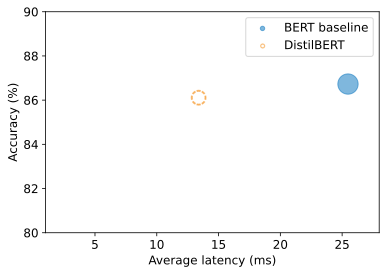

In [33]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")
    
    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그린다.
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"]*100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker="$\u25CC$")
        else :
            plt.scatter(df_opt["time_avg_ms"], df_opt['accuracy']*100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx)
    
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    
    plt.ylim(80, 90)
    # 가장 느린 모델을 사용해 X 축 범위를 정합니다.
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## 8.3.5 옵투나로 좋은 하이퍼파라미터 찾기
이제 좋은 α와 T를 찾아야지

이런 작업을 위해 설계된 최적화 프레임워크 Optuna를 사용하는 방법이 그리드 서치보다 더 좋다.

옵투나는 검색 문제를 여러 시도를 통해 최적화할 목적 함수로 표현한다.

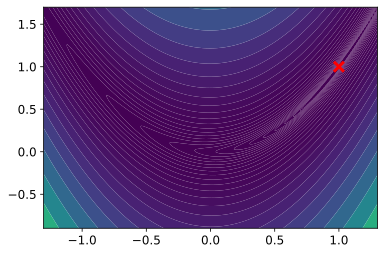

In [34]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

옵투나에서는 f(x,y)의 값을 반환하는 objective() 함수를 정의해 f(x,y)의 최소값을 찾는다.

In [35]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

trial.suggest_float() 메서드: 균등하게 샘플링할 파라미터 범위를 지정.  
옵투나는 정수와 범주형 파라미터를 위해 각각 suggest_int와 suggest_categorical도 제공

옵투나는 여러 시도를 하나의 study로 수집하므로 다음처럼 objective() 함수를 study.optimize() 메서드에 전달한다.

In [36]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-08-03 15:39:50,671] A new study created in memory with name: no-name-8354a85f-2351-4691-b74d-b74e8eebb3bc
[I 2023-08-03 15:39:50,673] Trial 0 finished with value: 8.131464089545833 and parameters: {'x': 1.1636094643959236, 'y': 1.6386744639778645}. Best is trial 0 with value: 8.131464089545833.
[I 2023-08-03 15:39:50,673] Trial 1 finished with value: 802.5670731392961 and parameters: {'x': -1.4263374402980924, 'y': -0.7881134718512959}. Best is trial 0 with value: 8.131464089545833.
[I 2023-08-03 15:39:50,674] Trial 2 finished with value: 3.3803960016667585 and parameters: {'x': -0.7082292873915876, 'y': 0.433592495435251}. Best is trial 2 with value: 3.3803960016667585.
[I 2023-08-03 15:39:50,675] Trial 3 finished with value: 223.25642970477992 and parameters: {'x': 0.99506175234675, 'y': -0.5040288231923182}. Best is trial 2 with value: 3.3803960016667585.
[I 2023-08-03 15:39:50,676] Trial 4 finished with value: 367.5439998627095 and parameters: {'x': 0.11713595907543528, 'y'

[I 2023-08-03 15:39:50,955] Trial 42 finished with value: 2.0537325088996816 and parameters: {'x': 0.7896015083188768, 'y': 0.7652261408975812}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:50,964] Trial 43 finished with value: 3.5524530488436046 and parameters: {'x': 0.8248141352355016, 'y': 0.4926547500873353}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:50,972] Trial 44 finished with value: 9.636860212358899 and parameters: {'x': 0.9951254698563771, 'y': 0.6798421565332584}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:50,980] Trial 45 finished with value: 6.765935874364725 and parameters: {'x': 0.5810452642186666, 'y': 0.08089560586183298}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:50,988] Trial 46 finished with value: 32.412657760552264 and parameters: {'x': 1.3328304219208675, 'y': 1.208089489943823}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:50,996] Tria

[I 2023-08-03 15:39:51,316] Trial 85 finished with value: 93.44453902967031 and parameters: {'x': 1.0352509507908128, 'y': 0.10508380262505644}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,324] Trial 86 finished with value: 3.3386309347529237 and parameters: {'x': 0.5821047536520148, 'y': 0.5167221511163886}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,333] Trial 87 finished with value: 7.600402114750241 and parameters: {'x': 0.762912054981139, 'y': 0.30736788860796105}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,342] Trial 88 finished with value: 111.76399907335635 and parameters: {'x': 0.942613007099497, 'y': -0.16865007995414583}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,350] Trial 89 finished with value: 24.990371273399578 and parameters: {'x': 0.468155234458962, 'y': 0.7162358424274835}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,359] Tri

[I 2023-08-03 15:39:51,692] Trial 127 finished with value: 6.19898128873581 and parameters: {'x': 0.7953816828756067, 'y': 0.38449672301721183}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,701] Trial 128 finished with value: 2.127907147943112 and parameters: {'x': 0.22400148061156167, 'y': -0.0733439198208124}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,710] Trial 129 finished with value: 0.2599498967858537 and parameters: {'x': 0.6989600367083098, 'y': 0.5296942322112799}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,719] Trial 130 finished with value: 11.49692654121346 and parameters: {'x': 0.9052456749938567, 'y': 0.48053097421829366}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,728] Trial 131 finished with value: 5.313192793789845 and parameters: {'x': 0.6574684127013597, 'y': 0.6602091127427181}. Best is trial 41 with value: 0.1350233416185288.
[I 2023-08-03 15:39:51,737

[I 2023-08-03 15:39:52,069] Trial 169 finished with value: 31.993177077196044 and parameters: {'x': 0.9910319965104113, 'y': 0.41652001400068084}. Best is trial 154 with value: 0.1167634805355392.
[I 2023-08-03 15:39:52,078] Trial 170 finished with value: 1.0326263447254924 and parameters: {'x': 0.6487272884134692, 'y': 0.5162008480312653}. Best is trial 154 with value: 0.1167634805355392.
[I 2023-08-03 15:39:52,087] Trial 171 finished with value: 0.8780302315820273 and parameters: {'x': 0.7214384599374055, 'y': 0.6099404118577683}. Best is trial 154 with value: 0.1167634805355392.
[I 2023-08-03 15:39:52,097] Trial 172 finished with value: 6.062364546718178 and parameters: {'x': 0.857471368836375, 'y': 0.4894513279382223}. Best is trial 154 with value: 0.1167634805355392.
[I 2023-08-03 15:39:52,106] Trial 173 finished with value: 0.05702668752817275 and parameters: {'x': 0.7647297538397607, 'y': 0.5807194101952041}. Best is trial 173 with value: 0.05702668752817275.
[I 2023-08-03 15:39

[I 2023-08-03 15:39:52,463] Trial 211 finished with value: 0.15338224754133017 and parameters: {'x': 0.6216496723852181, 'y': 0.39656428133669386}. Best is trial 173 with value: 0.05702668752817275.
[I 2023-08-03 15:39:52,473] Trial 212 finished with value: 0.8684134700558431 and parameters: {'x': 0.6125145858514716, 'y': 0.29042339376129817}. Best is trial 173 with value: 0.05702668752817275.
[I 2023-08-03 15:39:52,482] Trial 213 finished with value: 3.245792624836757 and parameters: {'x': 0.446119657416587, 'y': 0.3704581357146071}. Best is trial 173 with value: 0.05702668752817275.
[I 2023-08-03 15:39:52,492] Trial 214 finished with value: 1.2792147843416102 and parameters: {'x': 0.634489143071733, 'y': 0.5096099533167359}. Best is trial 173 with value: 0.05702668752817275.
[I 2023-08-03 15:39:52,501] Trial 215 finished with value: 0.04949617816369656 and parameters: {'x': 0.780372189876511, 'y': 0.605431384106681}. Best is trial 215 with value: 0.04949617816369656.
[I 2023-08-03 15

[I 2023-08-03 15:39:52,877] Trial 253 finished with value: 0.024300779010505143 and parameters: {'x': 0.8441226187354778, 'y': 0.712369184626313}. Best is trial 226 with value: 0.005680741628251121.
[I 2023-08-03 15:39:52,887] Trial 254 finished with value: 4.448488368708159 and parameters: {'x': 0.8452676339396511, 'y': 0.9248234274676288}. Best is trial 226 with value: 0.005680741628251121.
[I 2023-08-03 15:39:52,897] Trial 255 finished with value: 4.938959639329438 and parameters: {'x': 0.9668849461712613, 'y': 0.7126534699795094}. Best is trial 226 with value: 0.005680741628251121.
[I 2023-08-03 15:39:52,908] Trial 256 finished with value: 1.1004179927798827 and parameters: {'x': 0.8597974493278607, 'y': 0.8432113209327299}. Best is trial 226 with value: 0.005680741628251121.
[I 2023-08-03 15:39:52,918] Trial 257 finished with value: 0.4562798958484332 and parameters: {'x': 0.8160201318660342, 'y': 0.7308835710858307}. Best is trial 226 with value: 0.005680741628251121.
[I 2023-08-

[I 2023-08-03 15:39:53,312] Trial 295 finished with value: 0.2584909949811976 and parameters: {'x': 0.7968046711202267, 'y': 0.6815026893693543}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,322] Trial 296 finished with value: 0.30356400184973653 and parameters: {'x': 0.9061102336781003, 'y': 0.7667449908339387}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,333] Trial 297 finished with value: 21.730362830702898 and parameters: {'x': 1.035291290021545, 'y': 0.6056830417538984}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,344] Trial 298 finished with value: 833.9464200319647 and parameters: {'x': -1.9222458818280983, 'y': 0.8220396739447349}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,354] Trial 299 finished with value: 322.5552440227441 and parameters: {'x': 0.781166189435001, 'y': -1.18562836417565}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03

[I 2023-08-03 15:39:53,772] Trial 337 finished with value: 12.048038565917599 and parameters: {'x': 0.9675339660465003, 'y': 0.5890343132909694}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,784] Trial 338 finished with value: 58.270681480804086 and parameters: {'x': 1.3124651845213755, 'y': 0.9598522870035903}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,795] Trial 339 finished with value: 4.252433426255697 and parameters: {'x': 0.7338126041579233, 'y': 0.7429700012139214}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,806] Trial 340 finished with value: 0.11219451039843235 and parameters: {'x': 0.8464463768176895, 'y': 0.6867030635621407}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:53,818] Trial 341 finished with value: 52.34749273240481 and parameters: {'x': -0.31695895927509465, 'y': 0.8118919089684349}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-0

[I 2023-08-03 15:39:54,253] Trial 379 finished with value: 30.36012479672831 and parameters: {'x': 1.1689059687672767, 'y': 0.8155998854463073}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,265] Trial 380 finished with value: 2.629896100621738 and parameters: {'x': 0.8982529084445309, 'y': 0.9687083301605558}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,277] Trial 381 finished with value: 198.04269214755433 and parameters: {'x': -1.4588324515787492, 'y': 0.7425628960387785}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,288] Trial 382 finished with value: 3.0769918207780527 and parameters: {'x': 0.6817855304681878, 'y': 0.6373345927792089}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,300] Trial 383 finished with value: 141.2760839401272 and parameters: {'x': 0.8447633521745691, 'y': -0.47486966435320155}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08

[I 2023-08-03 15:39:54,753] Trial 421 finished with value: 50.07519678537086 and parameters: {'x': 0.8252523502555962, 'y': 1.3884639465050754}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,765] Trial 422 finished with value: 35.80928813851443 and parameters: {'x': 0.44520791194268666, 'y': 0.7940413854569938}. Best is trial 270 with value: 0.005347701402861605.
[I 2023-08-03 15:39:54,778] Trial 423 finished with value: 0.0016475370836010962 and parameters: {'x': 0.9601378423636792, 'y': 0.9210995262085571}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:54,791] Trial 424 finished with value: 0.023125230210414422 and parameters: {'x': 1.1170856812349816, 'y': 1.2575841161755874}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:54,805] Trial 425 finished with value: 3.0608690049597005 and parameters: {'x': 1.1558996066251765, 'y': 1.1618464956570556}. Best is trial 423 with value: 0.0016475370836010962.
[I 

[I 2023-08-03 15:39:55,274] Trial 463 finished with value: 34.71537753987329 and parameters: {'x': 0.5972869247448784, 'y': 0.9445713683283844}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,286] Trial 464 finished with value: 629.0080441363452 and parameters: {'x': 1.271328378200145, 'y': -0.8915806599433789}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,299] Trial 465 finished with value: 223.95861375418616 and parameters: {'x': 0.9110891432828909, 'y': -0.6664148476778022}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,311] Trial 466 finished with value: 173.91946399743895 and parameters: {'x': -0.31895127948791335, 'y': -1.2104432083041838}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,324] Trial 467 finished with value: 54.18421901481841 and parameters: {'x': 0.514888401120591, 'y': 0.9996091176940272}. Best is trial 423 with value: 0.0016475370836010962.
[I 20

[I 2023-08-03 15:39:55,808] Trial 505 finished with value: 82.22281555233121 and parameters: {'x': -0.5796378228881014, 'y': 1.2288829114229185}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,822] Trial 506 finished with value: 38.84374213297534 and parameters: {'x': 0.40309665276100115, 'y': 0.7828694428703713}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,836] Trial 507 finished with value: 12.732200904389666 and parameters: {'x': -0.8140733676867528, 'y': 0.9699830629485449}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,850] Trial 508 finished with value: 5.8966050546801565 and parameters: {'x': 0.9577947043487394, 'y': 0.6745781140846696}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:55,864] Trial 509 finished with value: 38.473781833316515 and parameters: {'x': 1.0377447047006263, 'y': 1.6971749621682433}. Best is trial 423 with value: 0.0016475370836010962.
[I 2

[I 2023-08-03 15:39:56,369] Trial 547 finished with value: 54.808890735816696 and parameters: {'x': 1.3201207693644335, 'y': 1.003081005755667}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,382] Trial 548 finished with value: 35.280172508535415 and parameters: {'x': 0.7112868328746077, 'y': -0.08734009683098243}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,396] Trial 549 finished with value: 2.3055640955020147 and parameters: {'x': 0.8217609491120432, 'y': 0.8260821360094419}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,409] Trial 550 finished with value: 0.010149286856427062 and parameters: {'x': 0.9543323281940322, 'y': 0.9197300315035322}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,423] Trial 551 finished with value: 1.7925907629357316 and parameters: {'x': 1.0328232555022059, 'y': 0.9328764491580082}. Best is trial 423 with value: 0.0016475370836010962.
[I

[I 2023-08-03 15:39:56,947] Trial 589 finished with value: 0.9788769263817116 and parameters: {'x': 1.0304602300316474, 'y': 0.962956976616467}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,961] Trial 590 finished with value: 390.4017872672394 and parameters: {'x': 1.3088730508787016, 'y': -0.2624686698370444}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,975] Trial 591 finished with value: 178.73555785030342 and parameters: {'x': 0.8365463891583379, 'y': -0.63701039883387}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:56,989] Trial 592 finished with value: 53.72683536354896 and parameters: {'x': 0.6807997196684468, 'y': 1.195778819106831}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:57,002] Trial 593 finished with value: 30.779001918176228 and parameters: {'x': -1.113867680421571, 'y': 0.7277629544526307}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-0

[I 2023-08-03 15:39:57,537] Trial 631 finished with value: 45.38373664417305 and parameters: {'x': 0.8538258158480221, 'y': 0.055502601561259385}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:57,552] Trial 632 finished with value: 178.78611934562076 and parameters: {'x': 0.4669909986021551, 'y': 1.5541270768097684}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:57,566] Trial 633 finished with value: 57.097598725241795 and parameters: {'x': 1.1296396822246086, 'y': 0.5205674976625091}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:57,581] Trial 634 finished with value: 83.73316722639223 and parameters: {'x': -0.11850962316702701, 'y': 0.922241114399728}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:57,595] Trial 635 finished with value: 289.46039668393513 and parameters: {'x': -0.2862801502852259, 'y': 1.7784405715269127}. Best is trial 423 with value: 0.0016475370836010962.
[I 

[I 2023-08-03 15:39:58,156] Trial 673 finished with value: 1.325738652642676 and parameters: {'x': 0.6612707511182201, 'y': 0.3272335089392814}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,170] Trial 674 finished with value: 44.279078747394585 and parameters: {'x': 1.599891567377075, 'y': 1.8969373352701115}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,185] Trial 675 finished with value: 5.93625997338399 and parameters: {'x': 0.9988364691230345, 'y': 0.7540299073502582}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,200] Trial 676 finished with value: 530.6355893536614 and parameters: {'x': 0.7776238452792155, 'y': -1.6987467009509003}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,214] Trial 677 finished with value: 3.9230510856219003 and parameters: {'x': 0.8784406127615674, 'y': 0.9693514710201845}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-0

[I 2023-08-03 15:39:58,786] Trial 715 finished with value: 124.0171853983336 and parameters: {'x': 0.8721706279069095, 'y': -0.35287506276235703}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,801] Trial 716 finished with value: 82.2067454875445 and parameters: {'x': 0.15495427656833538, 'y': 0.9267435856951365}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,817] Trial 717 finished with value: 8.964721287795683 and parameters: {'x': 1.1453431623986376, 'y': 1.012752492912448}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,832] Trial 718 finished with value: 1380.2329412906995 and parameters: {'x': -1.3133147569792931, 'y': -1.9831438255830682}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:58,848] Trial 719 finished with value: 3.2923517396016204 and parameters: {'x': 1.0031276059183234, 'y': 0.8248168756146528}. Best is trial 423 with value: 0.0016475370836010962.
[I 20

[I 2023-08-03 15:39:59,451] Trial 757 finished with value: 3.6110588852905483 and parameters: {'x': 0.8667016675089902, 'y': 0.9407315451769424}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:59,467] Trial 758 finished with value: 637.7008333591607 and parameters: {'x': -0.7819498546618688, 'y': -1.907533360940099}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:59,483] Trial 759 finished with value: 104.31552734957424 and parameters: {'x': 0.3539596330253928, 'y': 1.1445918866001499}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:59,499] Trial 760 finished with value: 436.74263570604666 and parameters: {'x': -1.6810455254725793, 'y': 0.7533440825793558}. Best is trial 423 with value: 0.0016475370836010962.
[I 2023-08-03 15:39:59,515] Trial 761 finished with value: 501.83185712745 and parameters: {'x': 1.1895624887250236, 'y': -0.8250212696758434}. Best is trial 423 with value: 0.0016475370836010962.
[I 202

[I 2023-08-03 15:40:00,137] Trial 799 finished with value: 2.606871375436465 and parameters: {'x': 1.156690514066239, 'y': 1.1772369759277848}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,154] Trial 800 finished with value: 24.9120169634064 and parameters: {'x': 0.68226496716555, 'y': 0.9635925162121427}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,170] Trial 801 finished with value: 425.9722406919068 and parameters: {'x': 0.8422754948819294, 'y': -1.3544212189170848}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,187] Trial 802 finished with value: 0.8070033296248147 and parameters: {'x': 0.4902282380480201, 'y': 0.3142923728149945}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,203] Trial 803 finished with value: 129.29057324547875 and parameters: {'x': -1.4114151816859217, 'y': 0.880896837477433}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-

[I 2023-08-03 15:40:00,839] Trial 841 finished with value: 0.07198086324651551 and parameters: {'x': 0.8633987277153059, 'y': 0.7685486937868933}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,856] Trial 842 finished with value: 16.068785745007467 and parameters: {'x': 1.1755436235941878, 'y': 0.9814284649628392}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,873] Trial 843 finished with value: 11.300321815339949 and parameters: {'x': 0.9300452047063735, 'y': 1.2010707999099632}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,891] Trial 844 finished with value: 36.54438852728129 and parameters: {'x': -0.8742904286163208, 'y': 0.18965404391105173}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:00,908] Trial 845 finished with value: 37.60243360633374 and parameters: {'x': 0.6863834939177589, 'y': 1.0835280346397873}. Best is trial 768 with value: 0.0007282446571885969.
[I 2

[I 2023-08-03 15:40:01,570] Trial 883 finished with value: 3.943584433768166 and parameters: {'x': -0.9395986933053639, 'y': 0.9254533731014627}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:01,588] Trial 884 finished with value: 208.31123693678973 and parameters: {'x': 1.518208887617572, 'y': 0.8625897004200382}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:01,605] Trial 885 finished with value: 25.009299157480775 and parameters: {'x': -1.2582205271868951, 'y': 1.1369155870226102}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:01,623] Trial 886 finished with value: 4.738659070600579 and parameters: {'x': 0.9449791032450154, 'y': 0.6753704378120071}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:01,640] Trial 887 finished with value: 76.00874708285649 and parameters: {'x': 0.35823679685158855, 'y': 0.9977983061800579}. Best is trial 768 with value: 0.0007282446571885969.
[I 202

[I 2023-08-03 15:40:02,473] Trial 925 finished with value: 22.373936647003948 and parameters: {'x': -1.0828663531777565, 'y': 0.747916075523823}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:02,492] Trial 926 finished with value: 281.6502961724731 and parameters: {'x': 1.2747630722017624, 'y': -0.052998184215098026}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:02,510] Trial 927 finished with value: 733.1057527020937 and parameters: {'x': -1.9602838531949187, 'y': 1.1513516569487183}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:02,528] Trial 928 finished with value: 0.04582416459562303 and parameters: {'x': 0.9230368192535052, 'y': 0.8320217767310994}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:02,546] Trial 929 finished with value: 156.79772995561174 and parameters: {'x': 0.11269147642000366, 'y': -1.2363419176480304}. Best is trial 768 with value: 0.0007282446571885969.


[I 2023-08-03 15:40:03,253] Trial 967 finished with value: 204.83324567150052 and parameters: {'x': 1.1043313267174866, 'y': -0.21161394917908066}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:03,271] Trial 968 finished with value: 293.4037458601659 and parameters: {'x': -1.6711453089108432, 'y': 1.100778864753159}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:03,290] Trial 969 finished with value: 41.249867825259116 and parameters: {'x': 1.2565711529467005, 'y': 0.937223144082768}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:03,309] Trial 970 finished with value: 0.04065943844299949 and parameters: {'x': 0.9967640057660464, 'y': 1.0137000721123648}. Best is trial 768 with value: 0.0007282446571885969.
[I 2023-08-03 15:40:03,328] Trial 971 finished with value: 0.027848176506357944 and parameters: {'x': 0.9870906245957134, 'y': 0.9577101355296022}. Best is trial 768 with value: 0.0007282446571885969.
[I

In [37]:
# 최상의 파라미터 획득
study.best_params

{'x': 1.0099379426087436, 'y': 1.0174657000259584}

1000번의 시도를 통해 옵투나는 전역 최솟값에 상당히 가까운 x와 y값을 찾음.  
### 트랜스포머스에서 옵투나를 사용하기 위해 비슷한 로직을 사용한다.

### 먼저 최적화하려는 하이퍼파라미터 공간을 정의한다.  
다음처럼 α와 T 외에 훈련 에포크 횟수를 포함시키겠다.

In [38]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

### Trainer로 하이퍼파라미터 검색을 실행하는 법은 
트레이너의 hyperparameter_search() 메서드에 시도 횟수와 최적화 방향을 지정하고 하이퍼파라미터 검색 공간을 전달하면 된다.
https://huggingface.co/docs/transformers/hpo_train

hyperparameter_search() 메서드는 최대화된 목적 함수의 값과 해당 시도에 사용한 하이퍼파라미터를 담은 BestRun 객체를 반환한다.

In [39]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2023-08-03 15:40:03,882] A new study created in memory with name: no-name-63dde8c0-6cd3-47d9-8fe4-a2d5a0953deb
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.464600,0.245158,0.606129
2,0.211200,nan,0.006452
3,0.000000,nan,0.006452
4,0.000000,nan,0.006452
5,0.000000,nan,0.006452


[I 2023-08-03 15:42:53,383] Trial 0 finished with value: 0.0064516129032258064 and parameters: {'num_train_epochs': 5, 'alpha': 0.7119080837389683, 'temperature': 5}. Best is trial 0 with value: 0.0064516129032258064.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.579900,0.307784,0.646774
2,0.252400,0.140878,0.817097
3,0.160100,nan,0.006452
4,0.000000,nan,0.006452
5,0.000000,nan,0.006452


[I 2023-08-03 15:46:05,523] Trial 1 finished with value: 0.0064516129032258064 and parameters: {'num_train_epochs': 5, 'alpha': 0.3963802099627812, 'temperature': 3}. Best is trial 0 with value: 0.0064516129032258064.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.385500,0.194891,0.584194
2,0.163100,0.094813,0.834839
3,0.107900,nan,0.006452
4,0.000000,nan,0.006452
5,0.000000,nan,0.006452
6,0.000000,nan,0.006452
7,0.000000,nan,0.006452
8,0.000000,nan,0.006452
9,0.000000,nan,0.006452
10,0.000000,nan,0.006452


[I 2023-08-03 15:53:02,139] Trial 2 finished with value: 0.0064516129032258064 and parameters: {'num_train_epochs': 10, 'alpha': 0.8464935355851676, 'temperature': 17}. Best is trial 0 with value: 0.0064516129032258064.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.493000,nan,0.006452
2,0.000000,nan,0.006452
3,0.000000,nan,0.006452
4,0.000000,nan,0.006452
5,0.000000,nan,0.006452


[I 2023-08-03 15:56:06,188] Trial 3 finished with value: 0.0064516129032258064 and parameters: {'num_train_epochs': 5, 'alpha': 0.006916760475260353, 'temperature': 19}. Best is trial 0 with value: 0.0064516129032258064.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387600,0.200017,0.577097
2,0.168900,0.100555,0.820000
3,0.106400,0.067837,0.883548
4,0.086100,nan,0.006452
5,0.000000,nan,0.006452
6,0.000000,nan,0.006452
7,0.000000,nan,0.006452


[I 2023-08-03 16:00:33,460] Trial 4 finished with value: 0.0064516129032258064 and parameters: {'num_train_epochs': 7, 'alpha': 0.6155862960652855, 'temperature': 17}. Best is trial 0 with value: 0.0064516129032258064.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.393600,0.207446,0.560645


[I 2023-08-03 16:01:12,158] Trial 5 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398300,0.207197,0.574839


[I 2023-08-03 16:01:51,794] Trial 6 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.497300,0.254975,0.635484
2,0.207900,0.114016,0.832903
3,0.119900,0.069360,0.896452
4,0.086400,0.051416,0.905484
5,0.069900,0.042088,0.915806
6,0.061300,0.037756,0.916774
7,0.056400,0.034907,0.919355
8,0.053800,0.034118,0.920000


[I 2023-08-03 16:08:05,141] Trial 7 finished with value: 0.92 and parameters: {'num_train_epochs': 8, 'alpha': 0.021102337101901125, 'temperature': 4}. Best is trial 7 with value: 0.92.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.391200,0.204379,0.565806


[I 2023-08-03 16:08:45,482] Trial 8 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.416400,0.212896,0.601935
2,0.178100,0.103030,0.829032
3,0.109000,0.067013,0.892581
4,0.081700,0.051350,0.901935
5,0.067300,0.042630,0.914839
6,0.059600,0.038383,0.914516
7,0.055000,0.035577,0.918065
8,0.052600,0.034769,0.916774


[I 2023-08-03 16:14:31,378] Trial 9 finished with value: 0.9167741935483871 and parameters: {'num_train_epochs': 8, 'alpha': 0.8037140367246797, 'temperature': 8}. Best is trial 7 with value: 0.92.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408800,0.207973,0.600000


[I 2023-08-03 16:15:15,598] Trial 10 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.416700,0.213748,0.596452


[I 2023-08-03 16:15:51,591] Trial 11 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.440300,0.226512,0.609677
2,0.188100,0.107413,0.829677
3,0.113400,0.068442,0.892581
4,0.084200,0.051994,0.901290
5,0.068900,0.042884,0.912581
6,0.060700,0.038486,0.914194
7,0.056100,nan,0.006452
8,0.000000,nan,0.006452


[I 2023-08-03 16:20:37,131] Trial 12 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.407000,0.208296,0.582903


[I 2023-08-03 16:21:13,789] Trial 13 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.800700,0.412147,0.670968
2,0.312800,0.145796,0.832581
3,0.145900,0.073495,0.897742
4,0.093200,0.053219,0.911290
5,0.072600,0.043561,0.922903
6,0.062400,0.039160,0.924516
7,0.056600,0.036163,0.927097
8,0.053200,0.034946,0.926774
9,0.051500,0.034251,0.927419


[I 2023-08-03 16:26:39,211] Trial 14 finished with value: 0.9274193548387096 and parameters: {'num_train_epochs': 9, 'alpha': 0.5491291899999895, 'temperature': 2}. Best is trial 14 with value: 0.9274193548387096.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.799400,0.408643,0.670645
2,0.308900,0.141332,0.837097
3,0.173200,nan,0.006452
4,0.000000,nan,0.006452
5,0.000000,nan,0.006452
6,0.000000,nan,0.006452


[I 2023-08-03 16:30:12,469] Trial 15 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.496400,0.253266,0.639677
2,0.206700,0.112853,0.837097
3,0.118500,0.067792,0.898387
4,0.084700,0.050039,0.905484
5,0.070700,nan,0.006452
6,0.000000,nan,0.006452


[I 2023-08-03 16:33:48,264] Trial 16 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801900,0.411640,0.665484
2,0.311500,0.145344,0.835806
3,0.145700,0.073644,0.897097
4,0.093300,0.052976,0.911290
5,0.072600,0.043619,0.921935
6,0.062500,0.039366,0.923871
7,0.056700,0.036304,0.928387
8,0.053300,0.035060,0.927097
9,0.051500,0.034382,0.925806


[I 2023-08-03 16:39:14,161] Trial 17 finished with value: 0.9258064516129032 and parameters: {'num_train_epochs': 9, 'alpha': 0.3948243563810905, 'temperature': 2}. Best is trial 14 with value: 0.9274193548387096.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.911900,nan,0.006452


[I 2023-08-03 16:39:51,200] Trial 18 pruned. 
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.440600,0.224551,0.615161
2,0.184900,0.104017,0.835161
3,0.109400,0.064887,0.896452
4,0.084700,nan,0.006452
5,0.000000,nan,0.006452
6,0.000000,nan,0.006452


[I 2023-08-03 16:43:26,670] Trial 19 pruned. 


In [40]:
import pandas as pd
df_temp = pd.DataFrame.from_dict(clinc_enc["validation"])
df_temp.isnull().value_counts()

labels  input_ids  attention_mask
False   False      False             3100
Name: count, dtype: int64

In [41]:
print(best_run)

BestRun(run_id='14', objective=0.9274193548387096,
hyperparameters={'num_train_epochs': 9, 'alpha': 0.5491291899999895,
'temperature': 2}, run_summary=None)


  α값을 보니 48% 정도의 손실은 일반적인 크로스 엔트로피에서, 나머지 52% 정도의 손실은 지식 정제 항에서 얻을 때 효과가 가장 좋다고 한다.

### 이제 훈련 매개변수를 best_run의 값으로 바꾸고 최종 훈련을 실행해보자

In [42]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v) # object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여
    
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

Cloning https://huggingface.co/bh8648/distilbert-base-uncased-distilled-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 9.12k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 4.00k/4.00k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/4.00k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [43]:
distil_trainer.train()

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.717100,1.967033,0.730968
2,1.521600,1.006095,0.859032
3,0.805300,0.581012,0.913871
4,0.486400,0.428404,0.936129
5,0.353300,0.370112,0.941290
6,0.292700,0.343878,0.944516
7,0.264100,0.332555,0.945161
8,0.249400,0.325530,0.946129
9,0.242400,0.324220,0.945484


TrainOutput(global_step=2862, training_loss=0.7685739490887571, metrics={'train_runtime': 321.2085, 'train_samples_per_second': 427.293, 'train_steps_per_second': 8.91, 'total_flos': 743498049913920.0, 'train_loss': 0.7685739490887571, 'epoch': 9.0})

In [44]:
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/4.00k [00:00<?, ?B/s]

To https://huggingface.co/bh8648/distilbert-base-uncased-distilled-clinc
   9b12f43..2974f83  main -> main

To https://huggingface.co/bh8648/distilbert-base-uncased-distilled-clinc
   2974f83..21d4b46  main -> main



'https://huggingface.co/bh8648/distilbert-base-uncased-distilled-clinc/commit/2974f837579c5fd43952aa485dd1c94c5f0b92b2'

## 8.3.6 정제 모델 벤치마크 수행하기
정확도 높은 스튜던트 모델을 만듦 -> 이제 파이프라인을 만들고 벤치마크를 다시 수행해 테스트 세트에서 성능을 확인

In [45]:
distilled_ckpt = "bh8648/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 13.67 +\- 4.04
테스트 세트 정확도 - 0.879


/tmp/ipykernel_1484/1299828502.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


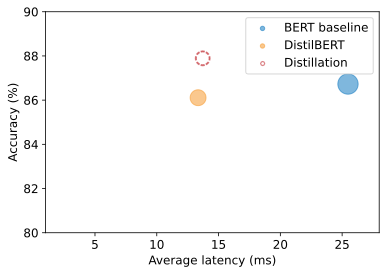

In [46]:
plot_metrics(perf_metrics, optim_type)

# 8.4 양자화로 모델 속도 높이기

신경망을 사용할 때 훈련에는 양방향 패스가 필요하지만 훈련된 모델을 가지고 추론을 수행할 때는 정방향 패스만 필요하다.  
따라서 정확도에 지대한 영향을 미치지 않고 데이터 타입의 정밀도를 낮추는 방법을 사용. -> 고정 소수점 포맷

고정 소수점 포맷은 동일 타입의 모든 변수에 대해 공통 비율로 스케일이 조정되는 B비트 정수로 실수를 표현한다.  
예를 들면 137.035는 1/1,000로 스케일이 조정되는 정수 137,035로 표현한다.

이 스케일링 인자를 조정해서 고정 소수점 숫자의 범위와 정밀도를 제어한다.

일반적으로 심층 신경망이 양자화의 주요 후보인 이유는  
가중치와 활성화의 값 범위가 비교적 좁기 때문이다.  
FP32 숫자의 전체 범위를 INT8로 표현하는 2^8 = 256개 숫자로 압축할 필요가 없다는 의미다.  
정제 모델의 어텐션 가중치 행렬 중 하나를 선택해 값의 빈도 분포를 그려 확인해보자

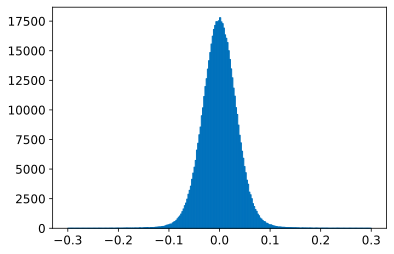

In [47]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

가중치 값이 원점에 가깝고 범위가 좁은 [-0.1, 0.1] 사이에 분포됨.  
이 텐서를 부호가 있는 8비트 정수로 압축한다고 해보자.  
이 경우 가능한 정수 범위는 [q_max, q_min] = [-128, 127] 이다.  
원점은 FP32의 원점과 일치하고 스케일링 인자는 책 P.303에 적힌 공식으로 계산된다.

In [48]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

### 양자화된 텐서를 얻으려면  
매핑을 뒤집어 q = f/S + Z를 계산하고, 범위 밖의 값을 클리핑하고, 가장 가까운 정수로 반올림하고, Tensor.char() 함수를 사용해 torch.int8 데이터 타입으로 결과를 표현하면 된다.

In [49]:
weights

tensor([[-0.0289, -0.0395,  0.0007,  ..., -0.0343, -0.0184,  0.0427],
        [ 0.0460,  0.0133,  0.0069,  ..., -0.0222,  0.0365,  0.0019],
        [-0.0475, -0.0293,  0.0286,  ...,  0.0024,  0.0293, -0.0188],
        ...,
        [ 0.0297,  0.0008,  0.0658,  ...,  0.0003,  0.0336, -0.0040],
        [ 0.0013, -0.0120, -0.0650,  ...,  0.0612, -0.0388, -0.0712],
        [-0.0681, -0.0045, -0.0513,  ...,  0.0428,  0.0110, -0.0072]])

In [50]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -3,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

### 파이토치에서는 quantize_per_tensor() 함수와  
### 정수 산술 연산에 최적화된 양자화 데이터 타입 torch.qint를 사용해 간단히 변환 가능

In [51]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -3,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   6,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

### FP32와 INT8 값의 가중치 텐서를 사용해 곱셈할 때 걸리는 시간을 비교
FP32 텐서의 경우 파이토치의 @ 연산자를 사용해 곱셈을 수행한다.

In [52]:
%%timeit
weights @ weights

2.46 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


양자화된 텐서의 경우 torch.qint8 데이터 타입으로 연산을 수행하는 QFunctional wraper 클래스가 필요

In [53]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [54]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

164 µs ± 87.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


FP32 계산과 비교하면 INT8 텐서가 훨씬 빠르다.  
양자화 연산을 효율적으로 실행하는 전용 백엔드를 사용하면 차이가 더 커진다.

FP32 숫자와 비교하면 INT8 숫자는 사용하는 비트 수가 1/4 이므로 양자화는 메모리 저장량도 1/4까지 줄일 수 있다.

### 이 예제의 가중치 텐서와 양자화된 텐서의 저장 크기를 비교해서 확인해보자.
파이썬 sys 모듈의 getsizeof() 함수와 Tensor.storage() 함수를 사용한다.

In [55]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/tmp/ipykernel_1484/2122423139.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

### 완전한 규모의 트랜스포머에서 실제 압축 비율은 어떤 층을 양자화했는지에 따라 다르다. (보통 선형 층만 양자화한다.)

### 양자화에서 주의할 점
-> 모델에 있는 모든 연산에서 정밀도를 바꾸면 모델의 계산 그래프 각 지점에서 작은 변동이 생기고, 이는 모델 성능에 나쁜 영향을 미친다.

### 심층 신경망에서 일반적으로 사용하는 양자화 방법은 세 가지다.
1. 동적 양자화
2. 정적 양자화
3. 양자화를 고려한 훈련

### 1. 동적 양자화
훈련 도중에 아무것도 바뀌지 않고 추론 과정에만 적응됨.  
모델 가중치가 추론 전에 INT8로 변환된다.  
'가중치' 외에 모델의 '활성화'도 양자화되는데(활성함수의 출력값을 양자화), 이 양자화가 즉석에서 일어나기 때문에 동적인 방식이다. -> 모든 행렬 곱셈이 고도로 최적화된 INT8 함수로 계산된다는 뜻.  
  
동적 양자화에서는 부동 소수점 포맷으로 활성화를 메모리에 쓰고 읽는다.  
따라서 정수와 부동 소수점 간의 변환이 성능 병목이 되는 경우도 있다.

### 2. 정적 양자화
즉석에서 활성화를 양자화하지 않고 양자화 체계(scheme)를 사전에 계산해 부동 소수점 변환을 피하는 방법.  
정적 양자화는 추론에 앞서 대표 샘플 데이터에서 활성화 패턴을 관찰 후 이상적인 양자화 체계를 계산해 저장한다. -> INT8과 FP32 간의 전환을 피하고 계산 속도를 높일 수 있다.  
  
하지만 좋은 데이터 샘플을 찾아야 하고 파이프라인에 추가 단계를 도입해야 한다.(추론을 수행하기 전에 양자화 체계를 훈련하고 결정해야 하기 때문)  
  
정적 양자화가 해결하지 못하는 하나는 훈련과 추론 과정에서 정밀도의 차이로 모델 성능(가령 정확도)이 떨어지는 것이다.

### 3. 양자화를 고려한 훈련
가짜로 FP32 값을 양자화해 훈련 중에 양자화의 효과를 시뮬레이션 하는 것.  
훈련할 떄 INT8을 사용하는 대신 FP32를 반올림해 양자화 효과를 흉내낸다.  
정방향 패스와 역방향 패스에서 모두 적용되며 정적 양자화와 동적 양자화를 사용해 모델 성능을 향상한다.

### NLP에서 동적 양자화는 트랜스포머 기반 모델에 대한 최상의 선택이다.
(트랜스포머로 추론을 실행할 때 주요 병목지점은 많은 개수의 모델 가중치에 연관된 계산과 메모리 대역폭이다.)
### 이보다 작은 컴퓨터 비전 모델에서는 정적 양자화를 일반적으로 사용한다.
(작은 컴퓨터 비전 모델에서는 활성화에 대한 메모리 대역폭이 제약요소이므로)

### 파이토치에서 동적 양자화는 매우 간단히 코드 한 줄로 구현

In [56]:
from torch.quantization import quantize_dynamic

# `bh8648`을 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "bh8648/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt)
         .to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

quantize_dynamic()에 완전한 정밀도 모델을 전달하고 이 모델에서 양자화할 파이토치 클래스를 지정.  
dtype 매개변수는 타깃 정밀도를 나타내며 fp16 또는 qint8로 지정한다.  
평가 지표 측면에서 수용 가능한 가장 낮은 정밀도를 선택하는 편이 좋다.  
이 장에서는 INT8을 사용.  

# 8.5 양자화된 모델의 벤치마크 수행하기

양자화된 모델을 벤치마크 클래스에 전달하고 결과를 시각화

In [57]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 6.69 +\- 2.28
테스트 세트 정확도 - 0.885


/tmp/ipykernel_1484/1299828502.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


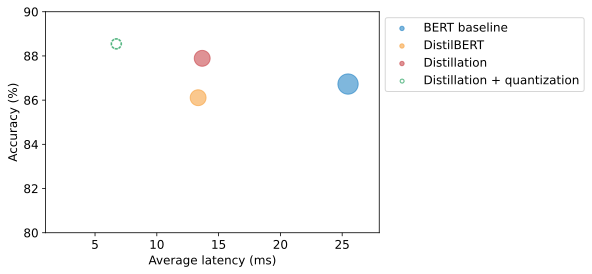

In [58]:
plot_metrics(perf_metrics, optim_type)

# 8.6 ONNX와 ONNX 런타임으로 추론 최적화하기
ONNX는 파이토치, 텐소플로를 비롯해 다양한 프레임워크에서 딥러닝 모델을 나타내기 위해 공통 연산자와 공통 파일 포맷을 정의하는 공개 표준이다.  
사이킷런 같은 프레임워크나 랜덤 포레스트 같은 전통적 머신러닝 모델을 위해 설계된 ONNX-ML 이라는 표준이 별도로 있다.

ONNX 런타임 또는 짧게 줄여서 ORT 같은 전용 가속기와 함께 사용할 때 빛난다. (인기 있는 그 외 가속기로는 NVIDIA의 TensorRT와 아파치의 TVM이 있다.)  

ORT는 연산자 융합operator fusion과 상수 폴딩constant folding 같은 ONNX 그래프를 최적화하는 도구를 제공한다.  
그리고 여러 종류의 하드웨어에서 모델을 실행하도록 '실행 공급자execution provider'를 위한 인터페이스를 정의한다. (-> 강력한 추상화)

#### ※융합된 연산은 한 연산자(일반적으로 활성화 함수)를 다른 연산자와 합쳐서 실행한다.  
예를 들어 행렬 곱셈 A x B에 활성화 함수 f를 적용한다고 가정.  
일반적으로 활성화를 계산하기 전, 곱셈의 결과를 GPU 메모리에 다시 저장해야 한다.  
연산자 융합을 사용하면 한 번에 f(A x B)가 계산된다.

#### ※ 상수 폴딩은 실행이 아니라 컴파일 시 상수 표현식을 평가하는 과정을 의미한다.

### ORT를 실행하려면 먼저 정제된 모델을 ONNX 포맷으로 변환해야 한다.  
트랜스포머스 라이브러리에는 아래의 4가지 단계로 이 과정을 처리하는 convert_graph_to_onnx.convert() 내장 함수가 있다.  
1. 하나의 파이프라인으로 모델을 초기화한다.
2. ONNX가 계산 그래프를 기록하도록 placeholder 입력으로 파이프라인을 실행한다.  
-> ※플레이스홀더 입력: 모델에 입력 데이터가 들어갈 자리를 미리 지정하는 역할
3. 동적 시퀀스 길이를 처리하기 위해 동적인 축을 정의한다.
4. 네트워크 파라미터와 함께 이 그래프를 저장한다.

### 이 함수를 사용하기 위해 먼저 ONNX를 위한 OpenMP 환경 변수를 지정한다.
https://openmp.org

In [59]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}" # ONNX 런타임에서 병렬 계산에 사용할 스레드 개수 지정
os.environ["OMP_WAIT_POLICY"] = "ACTIVE" # 대기 스레드를 활성 상태로 지정(즉, CPU 프로세서의 사이클을 사용)

### 정제된 모델을 ONNX 포맷으로 변환하기

In [60]:
from transformers.convert_graph_to_onnx import convert

# `bh8648`을 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "bh8648/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: bh8648/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='bh8648/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))
Creating folder onnx
Using framework PyTorch: 2.0.1+cu117
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



conver()가 변환하는 동안 트랜스포머스의 pipeline() 함수로 모델을 감싸기 때문에 pipeline_name="text-classification" 매개변수를 지정해줘야 한다.  
ONNX는 변경 불가능한 연산 규격을 그룹화하기 위해 연산자 집합(operator set)을 사용한다. 따라서 opset=12는 ONNX 라이브러리의 특정 버전에 해당한다.

### 모델을 저장했으니 모델에 입력을 전달하기 위해 InferenceSession 객체를 만든다.

In [61]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [62]:
onnx_model = create_model_for_provider(onnx_model_path)

### onnx_model.run()을 호출해 ONNX 모델에서 클래스 로짓을 얻기.
테스트 세트에 있는 샘플을 하나 사용해 테스트해보자.  
  
  convert()의 출력은 ONNX가 input_ids와 attention_mask만 입력으로 기대하는 것을 알려주므로 샘플에 있는 label 열은 삭제한다.

In [63]:
inputs = clinc_enc["test"][:1]

In [64]:
inputs

{'labels': [61],
 'input_ids': [[101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [65]:
del inputs["labels"]

In [66]:
inputs

{'input_ids': [[101, 2129, 2052, 2017, 2360, 4875, 1999, 3059, 102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [67]:
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [68]:
logits_onnx

array([[-1.6875741 , -2.4531667 , -1.7708576 , -1.7430799 , -2.6684773 ,
        -1.8909705 , -2.9488482 , -1.5496502 , -1.5673243 , -2.684062  ,
        -2.5739386 , -1.1874859 , -3.3605886 , -1.198247  , -2.8737118 ,
        -2.3759842 , -2.7363362 , -1.7311639 , -2.9470363 , -3.475533  ,
        -1.7077752 , -1.4889345 , -1.6132127 , -1.8189676 , -3.1051145 ,
        -2.513765  , -2.3649263 , -1.963563  , -0.87564296,  1.738919  ,
        -1.9015837 , -1.7204403 , -1.6464992 , -1.2557843 , -2.130134  ,
        -2.3043451 , -1.2544549 , -2.1440635 , -1.300312  , -2.066777  ,
        -1.7339933 , -1.9712014 , -0.45751387, -2.3934526 , -1.9418299 ,
        -2.4505572 , -2.7166972 , -1.5973544 , -2.0243442 , -3.4576583 ,
        -1.6596891 , -1.1518972 , -2.3534207 , -2.1540008 , -3.224942  ,
        -1.344228  , -2.3413548 , -1.8057369 , -3.0153594 , -2.3323803 ,
        -1.6433673 ,  5.469693  , -1.3904761 , -1.5027242 , -3.1057613 ,
        -2.9068298 , -1.9755089 , -1.8424935 , -1.9

로짓이 있으면 argmax를 적용해 쉽게 예측 레이블을 얻을 수 있다.

In [69]:
np.argmax(logits_onnx)

61

출력된 값과 정답 레이블을 비교해보자

In [70]:
clinc_enc["test"][0]["labels"]

61

In [71]:
id2label

{0: 'restaurant_reviews',
 1: 'nutrition_info',
 2: 'account_blocked',
 3: 'oil_change_how',
 4: 'time',
 5: 'weather',
 6: 'redeem_rewards',
 7: 'interest_rate',
 8: 'gas_type',
 9: 'accept_reservations',
 10: 'smart_home',
 11: 'user_name',
 12: 'report_lost_card',
 13: 'repeat',
 14: 'whisper_mode',
 15: 'what_are_your_hobbies',
 16: 'order',
 17: 'jump_start',
 18: 'schedule_meeting',
 19: 'meeting_schedule',
 20: 'freeze_account',
 21: 'what_song',
 22: 'meaning_of_life',
 23: 'restaurant_reservation',
 24: 'traffic',
 25: 'make_call',
 26: 'text',
 27: 'bill_balance',
 28: 'improve_credit_score',
 29: 'change_language',
 30: 'no',
 31: 'measurement_conversion',
 32: 'timer',
 33: 'flip_coin',
 34: 'do_you_have_pets',
 35: 'balance',
 36: 'tell_joke',
 37: 'last_maintenance',
 38: 'exchange_rate',
 39: 'uber',
 40: 'car_rental',
 41: 'credit_limit',
 42: 'oos',
 43: 'shopping_list',
 44: 'expiration_date',
 45: 'routing',
 46: 'meal_suggestion',
 47: 'tire_change',
 48: 'todo_list

In [72]:
logits_onnx.max()

5.469693

In [73]:
max(logits_onnx[0])

5.469693

#### ONNX 모델은 text-classification 파이프라인과 호환되지 않으므로 핵심 동작을 흉내내는 사용자 정의 클래스를 만들겠다.

In [74]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

간단한 쿼리로 이 클래스를 테스트해 car_rental 의도가 출력되는지 확인

In [75]:
query

"Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in \nParis and I need a 15 passenger van"

In [76]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.8823319}]

### ONNX 모델을 위한 성능 벤치마크를 만들기.

In [77]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    # 모델 크기를 계산할 때는 state_dict와 torch.save()에 의존하지 못하므로 compute_size() 메서드만 오버라이딩
    # (onnx_model이 기술적으로 파이토치의 nn.Module의 속성에 접근하지 못하는 ONNX InferenceSession 객체이기 때문)
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

새로운 벤치마크 클래스를 사용해 정제 모델이 ONNX 포맷으로 변환됐을 때 성능을 확인해보자

In [78]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                               model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 14.85 +\- 0.20
테스트 세트 정확도 - 0.879


/tmp/ipykernel_1484/1299828502.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


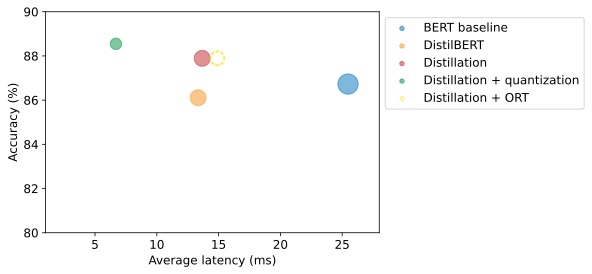

In [79]:
plot_metrics(perf_metrics, optim_type)

원래는 Distillation + ORT가 빨간 원의 왼쪽에 위치해서 레이턴시가 조금 향상되는듯 함.  
... 뭔데? 비슷하긴 한데 왜 ONNX 포맷이 좀 더 느려졌지...  
한 번 가지고 판단하긴 좀 그렇고 다시 돌리긴 귀찮음

#### 이제 양자화를 추가해 성능을 추가로 올려보자.

#### 파이토치와 비슷하게, ORT는 모델을 양자화하기 위해 세 가지 방법 제공.  
1) 동적 양자화
2) 정적 양자화
3) 양자화를 고려한 훈련

### 파이토치에서 했던 것처럼 정제 모델에 동적 양자화를 적용하겠다.

### ort에서 양자화는 quantize_dynamic() 함수를 통해 수행한다.
-> 이 함수에는 양자화할 ONNX 모델 경로, 양자화된 모델을 저장할 타깃 경로, 가중치를 축소할 데이터 타입을 전달한다.

In [80]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

### 모델을 양자화했으니 다시 벤치마크 실행

In [81]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT(quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.33
평균 레이턴시 (ms) - 8.48 +\- 0.21
테스트 세트 정확도 - 0.889


/tmp/ipykernel_1484/1299828502.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


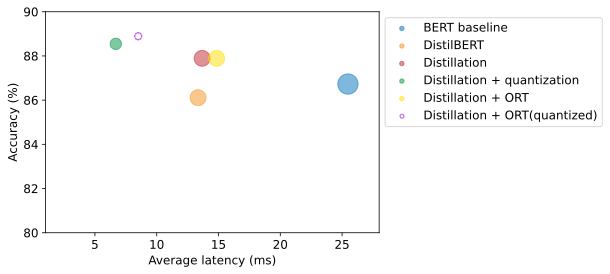

In [82]:
plot_metrics(perf_metrics, optim_type)

내가 ORT를 뭐 잘못했나 왜 ORT 적용한 모델들이 조금 더 느리지?  
원래는 노란게 빨간거 왼쪽, 보라색이 초록색 왼쪽에 있어야 함...  
흠흠

\<chatGPT>  
ORT적용한 모델이 아닌 모델보다 보다 평균 지연 시간(latency)이 더 오래 걸리는 이유는 다음과 같을 수 있습니다:

모델 변환의 오버헤드: 모델을 ONNX 포맷으로 변환하는 과정은 추가적인 계산 및 변환 오버헤드가 발생할 수 있습니다. 이러한 오버헤드가 평균 지연 시간을 증가시킬 수 있습니다.

모델 아키텍처: ONNX 포맷으로 변환된 모델 c는 원래 모델 b와 다른 아키텍처를 가지고 있을 수 있습니다. 이로 인해 모델 실행 속도에 차이가 발생할 수 있습니다.

런타임 환경: ONNX 런타임(ORT)은 모델을 실행하는 데 사용되는 라이브러리입니다. 런타임의 구현에 따라 성능 차이가 발생할 수 있으며, 이로 인해 c의 성능이 b보다 느릴 수 있습니다.

하드웨어 환경: 모델을 실행하는 환경에 따라 성능이 달라질 수 있습니다. 즉, c를 실행하는데 사용되는 하드웨어가 b를 실행하는데 사용되는 하드웨어와 다를 수 있습니다.

# 8.7 가중치 가지치기로 sparse model 만들기
지식 정제와 가중치 양자화는 추론 속도가 빠른 모델을 만드는 데 효과적이다.  
경우에 따라서는 모델의 메모리 사용량이 강력히 제한될 때도 있다.(모바일 장치에 삽입하는 어플 등)  
이러한 경우 분류기가 가능한 작은 공간을 사용해야 한다.  
#### -> 신경망에서 가장 덜 중요한 가중치를 찾아 제거하는 방식으로 모델의 파라미터 개수를 줄이는 방법

## 8.7.1 심층 신경망의 희소성
가지치기의 기본 개념 -> 훈련하는 동안 가중치 연결을(그리고 잠재적으로 뉴런을) 점진적으로 제거해 모델을 희소하게 만드는 것

이렇게 만들어진 가지치기된 모델은 0이 아닌 파라미터의 개수가 더 적어 희소 행렬 포맷으로 저장된다.  
가지치기는 양자화와 함께 사용하면 추가 압축이 가능하다.

## 8.7.2 가중치 가지치기 방법
수학적으로 대부분의 가중치 가지치기 방법이 동작하는 방식은 중요도 점수(importance score) 행렬 S를 계산하고 중요도 순으로 최상위 k%의 가중치를 선택하는 것이다.  
  
사실상 k는 모델의 희소성 양, 즉 값이 0인 가중치 비율을 제어하는 새로운 하이퍼파리미터 역할을 한다. -> k값이 낮을수록 행렬은 더 희소해짐  
  
그다음 이 점수를 사용해 마스크 행렬(mask matrix) M을 만든다.  
이 행렬은 정방향 패스에서 입력 x_i에 곱해지는 가중치 W_ij를 마스킹하여 희소한 활성함수 a_i를 만든다.

 #### 가지치기 방법은 다음과 같은 중요 질문을 고려해야 한다.
 1. 어떤 가중치를 삭제해야 할지
 2. 최상의 성능을 내려면 남은 가중치를 어떻게 조정해야 할지
 3. 이런 가지치기 계산을 효율적으로 수행하는 방법은 뭘지

### 절댓값 가지치기(magnitude pruning)
-> 가중치 절댓값 크기에 따라 점수를 계산한다.  
-> 그다음 마스크를 만든다. M = Top_k(S)  
-> 논문에서는 먼저 어떤 가중치가 중요한지 학습하도록 모델을 훈련하고 가장 덜 중요한 가중치를 가지치기 하는 식으로 반복적으로 절댓값 가지치기를 하는 경우가 일반적이다.  
-> 그다음 원하는 희소성에 도달할 떄까지 희소한 모델을 훈련하고 이 과정을 반복한다.

이 방식의 단점은 계산량이 많다는 것이다. (가지치기 매 단계마다 모델을 훈련해 수렴시켜야 함)  
따라서 보통 희소성 초깃값 s_i를 일정 단계 N 후에 최종 값으로 점진적으로 증가시키는 편이 낫다.

이 가지치기의 개념은  
-> Δt 스텝마다 이진 마스크 M을 업데이트해 / 훈련하는 동안 마스킹된 가중치를 다시 활성화하고 / 가지치기로 인해 발생할지 모를 잠재적인 정확도 손실을 복구하는 것.  
-> 세제곱 항은 가중치 가지치기의 속도가 (중복된 가중치가 많은) 초기 단계에 가장 높고 그후 점차 감소한다는 의미다.

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

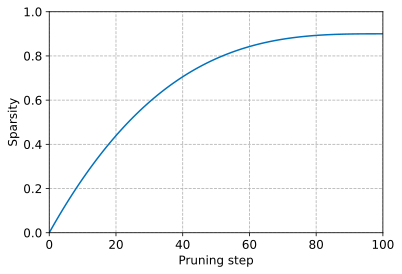

In [85]:
steps = np.linspace(0, 100, 100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0, 1)
ax.set_xlim(0, 100)
ax.set_xlabel("Pruning step") # 희소성이 높아진다 = 모델의 가중치를 더 많이 안쓴다. 그래서 곡선이 완만해짐
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

절댓값 가지치기는 각 가중치의 중요도가 현재 작업과 직접적으로 관련된 순수한 지도 학습을 위해 고안됐다는 문제가 있다.  
#### 이와 달리 전이 학습에서는 가중치의 중요도가 주로 사전 훈련 단계에서 결정된다.  
따라서 절댓값 가지치기로 인해 미세 튜닝 작업에서 중요한 가중치가 삭제될 수도 있다. -> 이러한 문제를 해결하기 위해 이동 가지치기가 제안됨

### 이동 가지치기(movement pruning)
이동 가지치기의 기본 개념은 미세 튜닝하는 동안 점진적으로 가중치를 제거해 모델을 점차 희소하게 만드는 것.  

이 방식의 새로운 점은 미세 튜닝하는 동안 가중치와 점수가 모두 학습된다는 것이다.  
따라서 이동 가지치기에서는 점수를 가중치에서 바로 구하지 않고 임의적이며 신경망의 다른 파라미터처럼 경사 하강법을 통해 학습한다. -> 즉 역방향 패스에서 점수 S_ij에 대한 손실 L의 그레이디언트도 추적한다.

점수를 학습하고 나면 M = Top_k(S)를 통해 이진 마스크를 생성하기는 쉽다.  
※ 최상위 k%의 가중치를 선택하는 대신 전역 임곗값(global thresholding; τ)을 사용해 이진마스크 M = (S > τ)를 정의하는 이동 가지치기의 소프트 버전도 있음.

이동 가지치기 개념에서는 직관적으로 -> 원점으로부터 가장 크게 이동하는 가중치가 가장 중요하다. -> 즉, 미세 튜닝하는 동안 '양의 가중치'가 증가한다.(그리고 음의 가중치는 반대로 줄어든다.)  
#### -> 이는 가중치가 원점에서 멀어질수록 점수가 증가한다는 말과 같다.
※ 이동 가지치기에서 점수 S_ij에 대한 손실의 그레이디언트가 0보다 작은 경우, 점수 S_ij가 증가한다. 이는 가중치 W_ij가 원점에서 멀어진다는 의미다.

절댓값 가지치기의 경우 사전 훈련된 가중치 값이 미세 튜닝의 가지치기에 큰 영향을 미쳐 원점에서 가장 멀리 있는 가중치들만 선택하지만,  
이동 가지치기에서는 전 영역에서 고르게 가지치기 된다.

### 가지치기 방법은 nn_pruning 라이브러리 확인 또는 허깅페이스에 가서 pruning 문서 검색